In [72]:
%load_ext dotenv
%dotenv

The dotenv extension is already loaded. To reload it, use:
  %reload_ext dotenv


### Imports

In [73]:
import pandas as pd
import lightgbm as lgbm
import os

### Importing Preprocessed Data

In [74]:
loc_pre = os.getenv("LOC_PRE")
loc_pre_train = f"{loc_pre}/train.csv"

In [75]:
df_train = pd.read_csv(loc_pre_train)
df_train.head(5)

/tmp/ipykernel_6640/1272283362.py:1: DtypeWarning: Columns (4,5,6,7,8) have mixed types. Specify dtype option on import or set low_memory=False.
  df_train = pd.read_csv(loc_pre_train)


,sales,store_nbr,family,onpromotion,type_x,locale,locale_name,description,transferred,dcoilwtico,city,state,type_y,cluster,transactions,year,month,day
0,0.0,1,AUTOMOTIVE,0,Holiday,National,Ecuador,Primer dia del ano,False,NaN,Quito,Pichincha,D,13,NaN,2013,1,1
1,0.0,1,BABY CARE,0,Holiday,National,Ecuador,Primer dia del ano,False,NaN,Quito,Pichincha,D,13,NaN,2013,1,1
2,0.0,1,BEAUTY,0,Holiday,National,Ecuador,Primer dia del ano,False,NaN,Quito,Pichincha,D,13,NaN,2013,1,1
3,0.0,1,BEVERAGES,0,Holiday,National,Ecuador,Primer dia del ano,False,NaN,Quito,Pichincha,D,13,NaN,2013,1,1
4,0.0,1,BOOKS,0,Holiday,National,Ecuador,Primer dia del ano,False,NaN,Quito,Pichincha,D,13,NaN,2013,1,1


In [76]:
cat_cols = [name for name,type in df_train.dtypes.items() if type=="object"]
cat_cols

['family',
 'type_x',
 'locale',
 'locale_name',
 'description',
 'transferred',
 'city',
 'state',
 'type_y']

In [77]:
for col in cat_cols:
    df_train[col] = df_train[col].astype("category")


### Splitting Train/Validation Data

In [78]:
def split_df(df:pd.DataFrame,test_pct:int=0.3):
    cnt = int(len(df)*test_pct)
    return df[:-cnt],df[-cnt:]

In [79]:
train,val = split_df(df_train)
train.shape,val.shape

((2138044, 18), (916304, 18))

In [80]:
lgb_train = lgbm.Dataset(train.iloc[:,1:],train.iloc[:,0])
lgb_val = lgbm.Dataset(val.iloc[:,1:],val.iloc[:,0],reference=lgb_train)

In [81]:
lgb_train.get_label()

0          0.000000
1          0.000000
2          0.000000
3          0.000000
4          0.000000
             ...   
2138039    3.218876
2138040    9.270683
2138041    0.000000
2138042    7.420679
2138043    4.094345
Name: sales, Length: 2138044, dtype: float64

In [82]:
params = {
    "objective": "rmse",
    "n_estimators":300,
    "learning_rate":0.1
}

In [83]:
eval_results={}

In [84]:
model = lgbm.train(
    params,
    lgb_train,
    valid_sets=[lgb_train,lgb_val],
    valid_names=["train","valid"],
    callbacks=[lgbm.record_evaluation(eval_results)],
)

/mnt/d/Work/03-Projects/06-Repos/kaggle-store-sales/.venv/lib/python3.8/site-packages/lightgbm/engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.070376 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 978
[LightGBM] [Info] Number of data points in the train set: 2138044, number of used features: 17


/mnt/d/Work/03-Projects/06-Repos/kaggle-store-sales/.venv/lib/python3.8/site-packages/lightgbm/basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
/mnt/d/Work/03-Projects/06-Repos/kaggle-store-sales/.venv/lib/python3.8/site-packages/lightgbm/basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


[LightGBM] [Info] Start training from score 2.685937


### Performance

<AxesSubplot:title={'center':'Metric during training'}, xlabel='Iterations', ylabel='l2'>

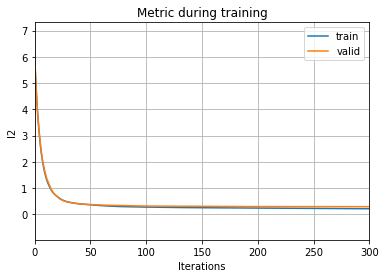

In [85]:
lgbm.plot_metric(eval_results)

In [86]:
eval_results["train"]["l2"][-1]
# l2 loss with day, month, and year time steps: 118983.70518049951
# l2 loss with n_estimators=3000, learningrate = 0.1: 36724.93942673205
# l2 loss with n_estimators=300, learningrate= 0.1, holidays events : 84760.06756100248
# + oil data: 55088.283702886634
# + stores data: 49055.45042322532
# + transactions data: 32101.803776301516
# + log transform: 0.21764610547912724

0.21764610547912724

In [87]:
eval_results["valid"]["l2"][-1]
# l2 loss with day, month, and year time steps: 277458.55905733566
# l2 loss with n_estimators=3000, learningrate = 0.1: 350617.34411903867
# l2 loss with n_estimators=300, learningrate= 0.1, holidays events : 299850.5490204666
# + oil data: 206853.0156635611
# + stores data: 192319.94402014153
# + transactions data: 146200.61708718364
# + log transform: 0.2962400467453479

0.2962400467453479

In [88]:
model.save_model("lgbm.pkl")